In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phantoms.utils.CKA.CKA import linear_CKA, kernel_CKA
import umap.umap_ as umap
from tqdm import tqdm
import re

In [33]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings



def compute_layer_cka(embeddings_model1, embeddings_model2, layer_name1, layer_name2):
    """
    Compute CKA scores between two sets of embeddings for a specific layer.
    """
    X = embeddings_model1.get(layer_name1)
    Y = embeddings_model2.get(layer_name2)
    
    if X is None or Y is None:
        print(f"Embeddings for layer '{layer_name1}' or '{layer_name2}' are missing.")
        return None, None

    # Transpose to shape (embedding_dim, num_samples)
    X = X.T
    Y = Y.T

    # Compute CKA scores
    linear_cka_score = linear_CKA(X, Y)
    rbf_cka_score = kernel_CKA(X, Y)
    
    return linear_cka_score, rbf_cka_score

def compute_cka_matrix_for_experiment(experiment_dir, layer_names):
    """
    For a single experiment directory, load the embeddings and compute a 3D
    CKA matrix of shape [num_layers, num_layers, 2] where the last dimension
    corresponds to (linear, RBF) CKA scores.
    """
    print(f"\nProcessing experiment: {experiment_dir}")
    embeddings = load_embeddings(experiment_dir, layer_names)
    num_layers = len(layer_names)
    cka_matrix = np.zeros((num_layers, num_layers, 2))
    
    # Loop over all pairs of layers
    for i, layer1 in enumerate(tqdm(layer_names, desc="Outer loop")):
        for j, layer2 in enumerate(layer_names):
            linear_cka, rbf_cka = compute_layer_cka(embeddings, embeddings, layer1, layer2)
            if linear_cka is not None and rbf_cka is not None:
                cka_matrix[i, j, 0] = linear_cka
                cka_matrix[i, j, 1] = rbf_cka
    return cka_matrix

def compute_all_cka_matrices(experiment_dirs, layer_names):
    """
    Compute a dictionary mapping each experiment directory (or label) to its 
    corresponding 3D CKA matrix.
    """
    cka_matrices = {}
    for exp_dir in experiment_dirs:
        cka_matrices[exp_dir] = compute_cka_matrix_for_experiment(exp_dir, layer_names)
    return cka_matrices

def plot_all_heatmaps(cka_matrices, layer_names, metric='linear'):
    """
    Plot a 2x2 grid of heatmaps corresponding to the CKA matrices computed
    for different experiment directories.
    
    Args:
        cka_matrices (dict): Dictionary with keys as experiment directory paths 
                             and values as CKA matrices (shape: [num_layers, num_layers, 2]).
        layer_names (list): List of layer names (used for x- and y-axis labels).
        metric (str): 'linear' for linear CKA or 'rbf' for RBF kernel CKA.
    """
    num_experiments = len(cka_matrices)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for ax, (exp_dir, cka_matrix) in zip(axes, cka_matrices.items()):
        # Select metric: index 0 for linear, 1 for RBF
        if metric.lower() == 'linear':
            data = cka_matrix[:, :, 0]
        else:
            data = cka_matrix[:, :, 1]
            
        # Create a boolean mask for the diagonal (we want to hide these cells)
        mask = np.eye(data.shape[0], dtype=bool)
        
        # Determine the maximum off-diagonal value for the color scale
        if np.sum(~mask) > 0:
            vmax = np.max(data[~mask])
        else:
            vmax = None
        
        sns.heatmap(data, ax=ax, annot=False, fmt=".2f",
                    xticklabels=layer_names, yticklabels=layer_names,
                    cmap='coolwarm', mask=mask, vmin=0, vmax=vmax)
        
        # Extract a simple title from the experiment directory (e.g. "cut_tree_3")
        match = re.search(r'cut_tree_\d+', exp_dir)
        if match:
            title = match.group(0)
        else:
            title = os.path.basename(exp_dir)
            
        ax.set_title(f"{title}\n{metric.upper()} CKA", fontsize=10)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Layers")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    
    plt.suptitle(f"Intra-Model {metric.upper()} CKA Heatmaps (Diagonal Masked)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def project_embeddings_umap(embeddings_dict, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42, figsize=(12, 10), save_path=None):
    """
    Projects embeddings into 2D space using UMAP and plots them colored by layer.

    Args:
        embeddings_dict (dict): A dictionary where keys are layer names and values are np arrays of shape [num_samples, embedding_dim].
        n_neighbors (int): UMAP parameter. Controls local versus global structure in the data.
        min_dist (float): UMAP parameter. Controls how tightly UMAP packs points together.
        metric (str): UMAP parameter. The metric to use for distance computation.
        random_state (int): Random state for reproducibility.
        figsize (tuple): Size of the matplotlib figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Validate input
    if not isinstance(embeddings_dict, dict):
        raise ValueError("embeddings_dict must be a dictionary with layer names as keys and embedding arrays as values.")

    # Collect embeddings and labels
    all_embeddings = []
    labels = []
    for layer, emb in embeddings_dict.items():
        if not isinstance(emb, np.ndarray):
            raise ValueError(f"Embeddings for layer '{layer}' must be a NumPy array.")
        all_embeddings.append(emb)
        labels.extend([layer] * emb.shape[0])

    # Concatenate all embeddings
    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Total embeddings shape after concatenation: {concatenated_embeddings.shape}")

    # Create a DataFrame for UMAP
    df_embeddings = pd.DataFrame(concatenated_embeddings)
    df_embeddings['Layer'] = labels

    # Initialize UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)

    # Fit and transform the embeddings
    embedding_2d = reducer.fit_transform(df_embeddings.drop('Layer', axis=1))
    df_embeddings['UMAP1'] = embedding_2d[:, 0]
    df_embeddings['UMAP2'] = embedding_2d[:, 1]

    # Debugging: Check the shape of the reduced embeddings
    print(f"UMAP embedding shape: {embedding_2d.shape}")

    # Plotting
    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=df_embeddings,
        x='UMAP1',
        y='UMAP2',
        hue='Layer',
        palette='tab10',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP Projection of Layer Embeddings', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"UMAP plot saved to {save_path}")

    plt.show()

In [4]:
os.listdir("/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-18_22-29-53")

['gnn_1_head_1.npy',
 'head_skipblock_3_hidden1.npy',
 'gnn_1_head_2.npy',
 'head_head_fc1.npy',
 'head_skipblock_3_hidden2.npy',
 'gnn_1_head_3.npy',
 'gnn_3.npy',
 'gnn_2.npy',
 'head_skipblock_6_hidden2.npy',
 'gnn_1_head_4.npy',
 'gnn_1.npy',
 'head_skipblock_6_hidden1.npy',
 'head_skipblock_5_hidden1.npy',
 'gnn_3_head_1.npy',
 'head_skipblock_5_hidden2.npy',
 'gnn_3_head_3.npy',
 'gnn_3_head_2.npy',
 'gnn_3_head_4.npy',
 'head_skipblock_2_hidden2.npy',
 'head_skipblock_2_hidden1.npy',
 'head_skipblock_1_hidden1.npy',
 'gnn_2_head_4.npy',
 'head_skipblock_1_hidden2.npy',
 'head_head_fc_final.npy',
 'head_skipblock_4_hidden2.npy',
 'gnn_2_head_1.npy',
 'gnn_2_head_3.npy',
 'head_skipblock_4_hidden1.npy',
 'gnn_2_head_2.npy']

In [20]:
experiment_dir1 = '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'
experiment_dir2 = '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'

# Specify the layers you want to compare
layer_names = ['gnn_1_head_1',
'gnn_1_head_2',
'gnn_1_head_3',
'gnn_1_head_4',
'gnn_2_head_1',
'gnn_2_head_2',
'gnn_2_head_3',
'gnn_2_head_4',
'gnn_3_head_1',
'gnn_3_head_2',
'gnn_3_head_3',
'gnn_3_head_4',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

In [21]:
embeddings_model1 = load_embeddings(experiment_dir1, layer_names)
embeddings_model2 = load_embeddings(experiment_dir2, layer_names)

In [22]:
# Compute and display CKA scores for each layer
for layer in layer_names:
    linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer, layer)
    if linear_cka is not None and rbf_cka is not None:
        print(f"Layer: {layer}")
        print(f"  Linear CKA: {linear_cka:.4f}")
        print(f"  RBF Kernel CKA: {rbf_cka:.4f}\n")

Layer: gnn_1_head_1
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_1_head_2
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_1_head_3
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_1_head_4
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_2_head_1
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_2_head_2
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_2_head_3
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_2_head_4
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_3_head_1
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_3_head_2
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_3_head_3
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: gnn_3_head_4
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: head_head_fc1
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: head_skipblock_1_hidden1
  Linear CKA: 1.0000
  RBF Kernel CKA: 1.0000

Layer: head_skipblock_1_hidden2
  Linear CKA: 1.0

In [23]:
for layer, layer_embeddings in embeddings_model2.items():
    print(layer, layer_embeddings.shape)

gnn_1_head_1 (1988, 1024)
gnn_1_head_2 (1988, 1024)
gnn_1_head_3 (1988, 1024)
gnn_1_head_4 (1988, 1024)
gnn_2_head_1 (1988, 1024)
gnn_2_head_2 (1988, 1024)
gnn_2_head_3 (1988, 1024)
gnn_2_head_4 (1988, 1024)
gnn_3_head_1 (1988, 1024)
gnn_3_head_2 (1988, 1024)
gnn_3_head_3 (1988, 1024)
gnn_3_head_4 (1988, 1024)
head_head_fc1 (1988, 1024)
head_skipblock_1_hidden1 (1988, 1024)
head_skipblock_1_hidden2 (1988, 1024)
head_skipblock_2_hidden1 (1988, 1024)
head_skipblock_2_hidden2 (1988, 1024)
head_skipblock_3_hidden1 (1988, 1024)
head_skipblock_3_hidden2 (1988, 1024)
head_skipblock_4_hidden1 (1988, 1024)
head_skipblock_4_hidden2 (1988, 1024)
head_skipblock_5_hidden1 (1988, 1024)
head_skipblock_5_hidden2 (1988, 1024)
head_skipblock_6_hidden1 (1988, 1024)
head_skipblock_6_hidden2 (1988, 1024)
head_head_fc_final (1988, 1024)


In [24]:
# Initialize a matrix to store CKA scores
# Rows: Model1 layers, Columns: Model2 layers
cka_matrix = np.zeros((len(layer_names), len(layer_names), 2))  # Last dim for linear and RBF

for i, layer1 in enumerate(tqdm(layer_names, desc="Processing outer layers")):
    for j, layer2 in enumerate(layer_names):
        linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer1, layer2)
        if linear_cka is not None and rbf_cka is not None:
            cka_matrix[i, j, 0] = linear_cka
            cka_matrix[i, j, 1] = rbf_cka

Processing outer layers: 100%|██████████| 26/26 [03:25<00:00,  7.89s/it]


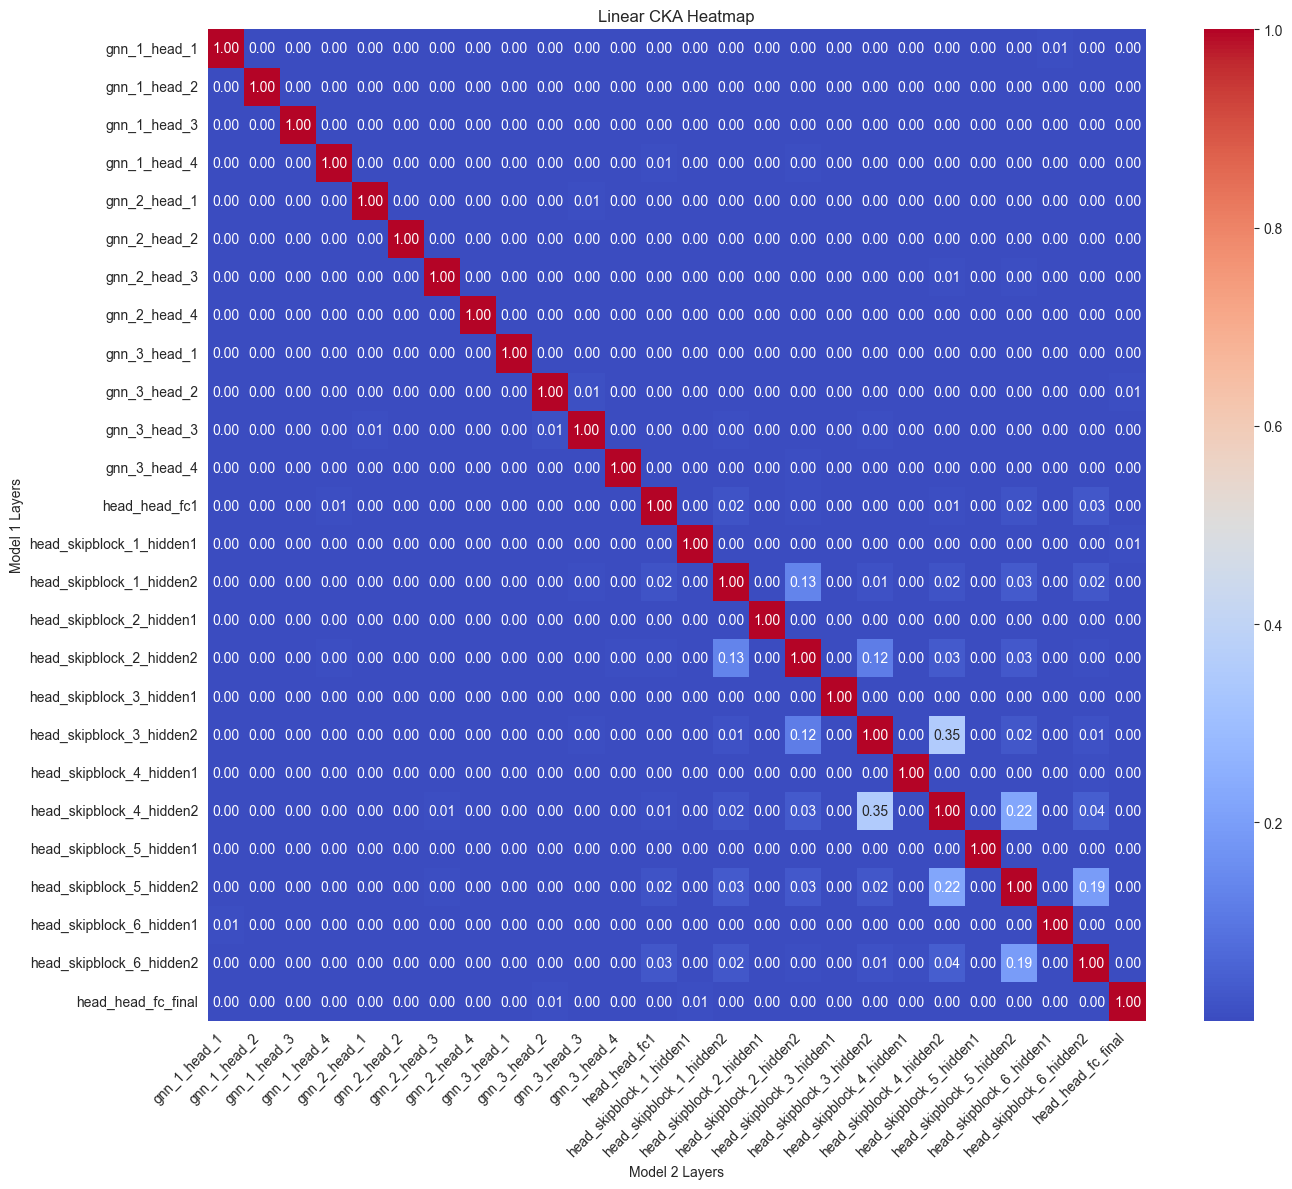

In [25]:
# Plot Linear CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:,:, 0], annot=True, fmt=".2f",
            xticklabels=layer_names, yticklabels=layer_names,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('Linear CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

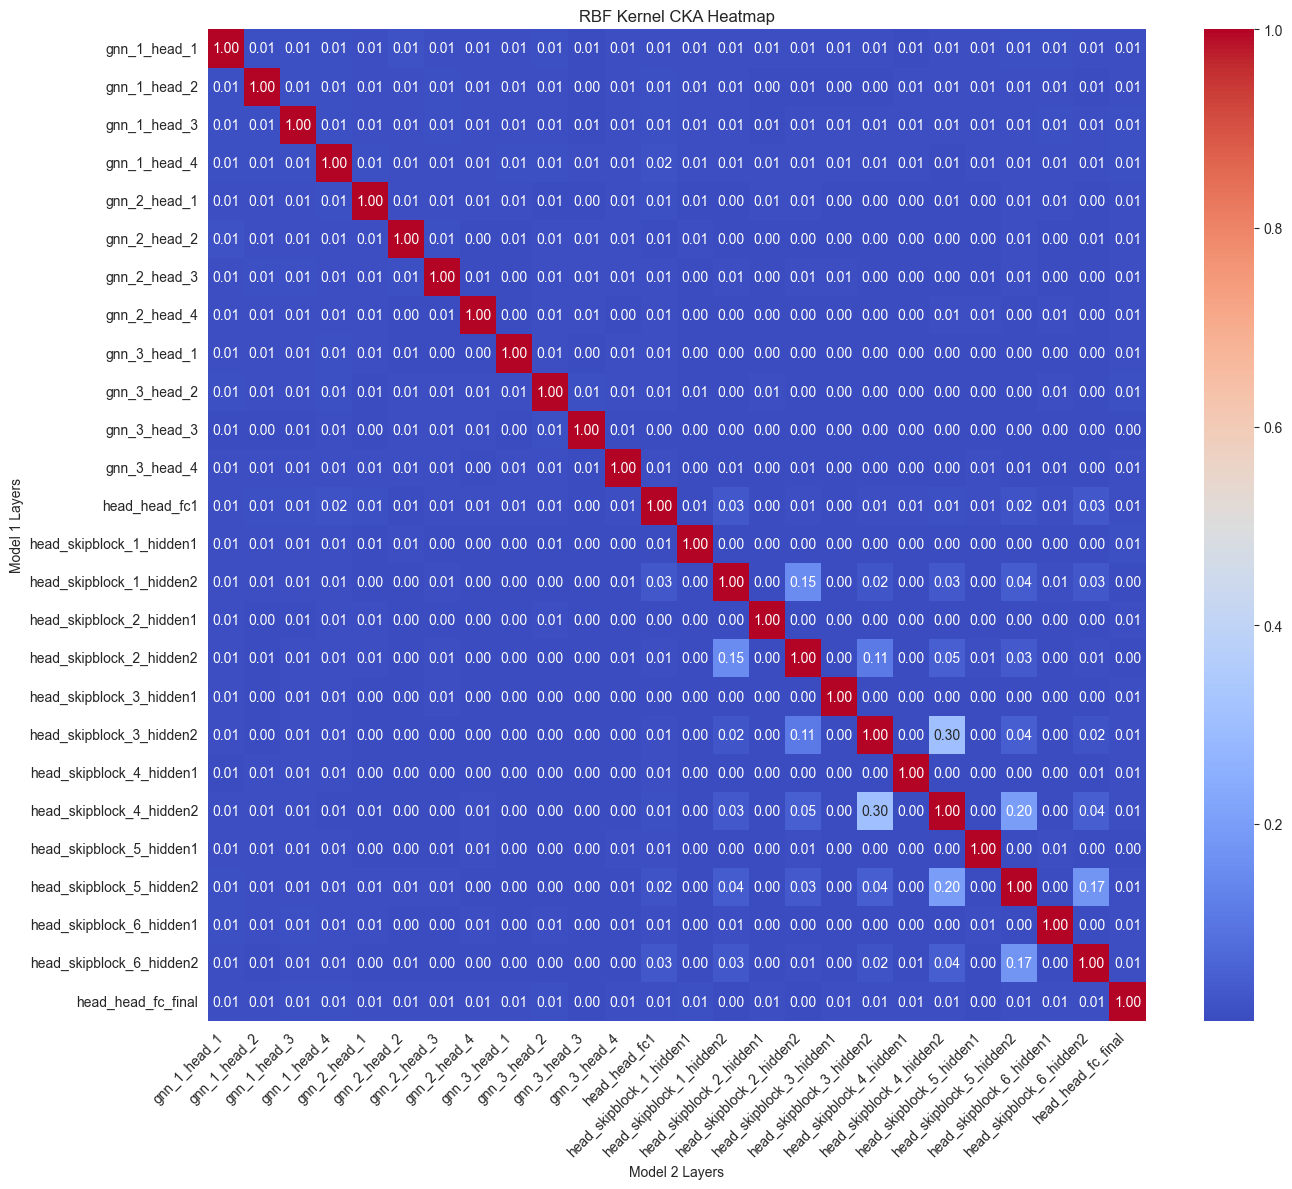

In [26]:
# Plot RBF Kernel CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:, :, 1], annot=True, fmt=".2f",
            xticklabels=layer_names, yticklabels=layer_names,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('RBF Kernel CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Total embeddings shape after concatenation: (51688, 1024)


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (51688, 2)


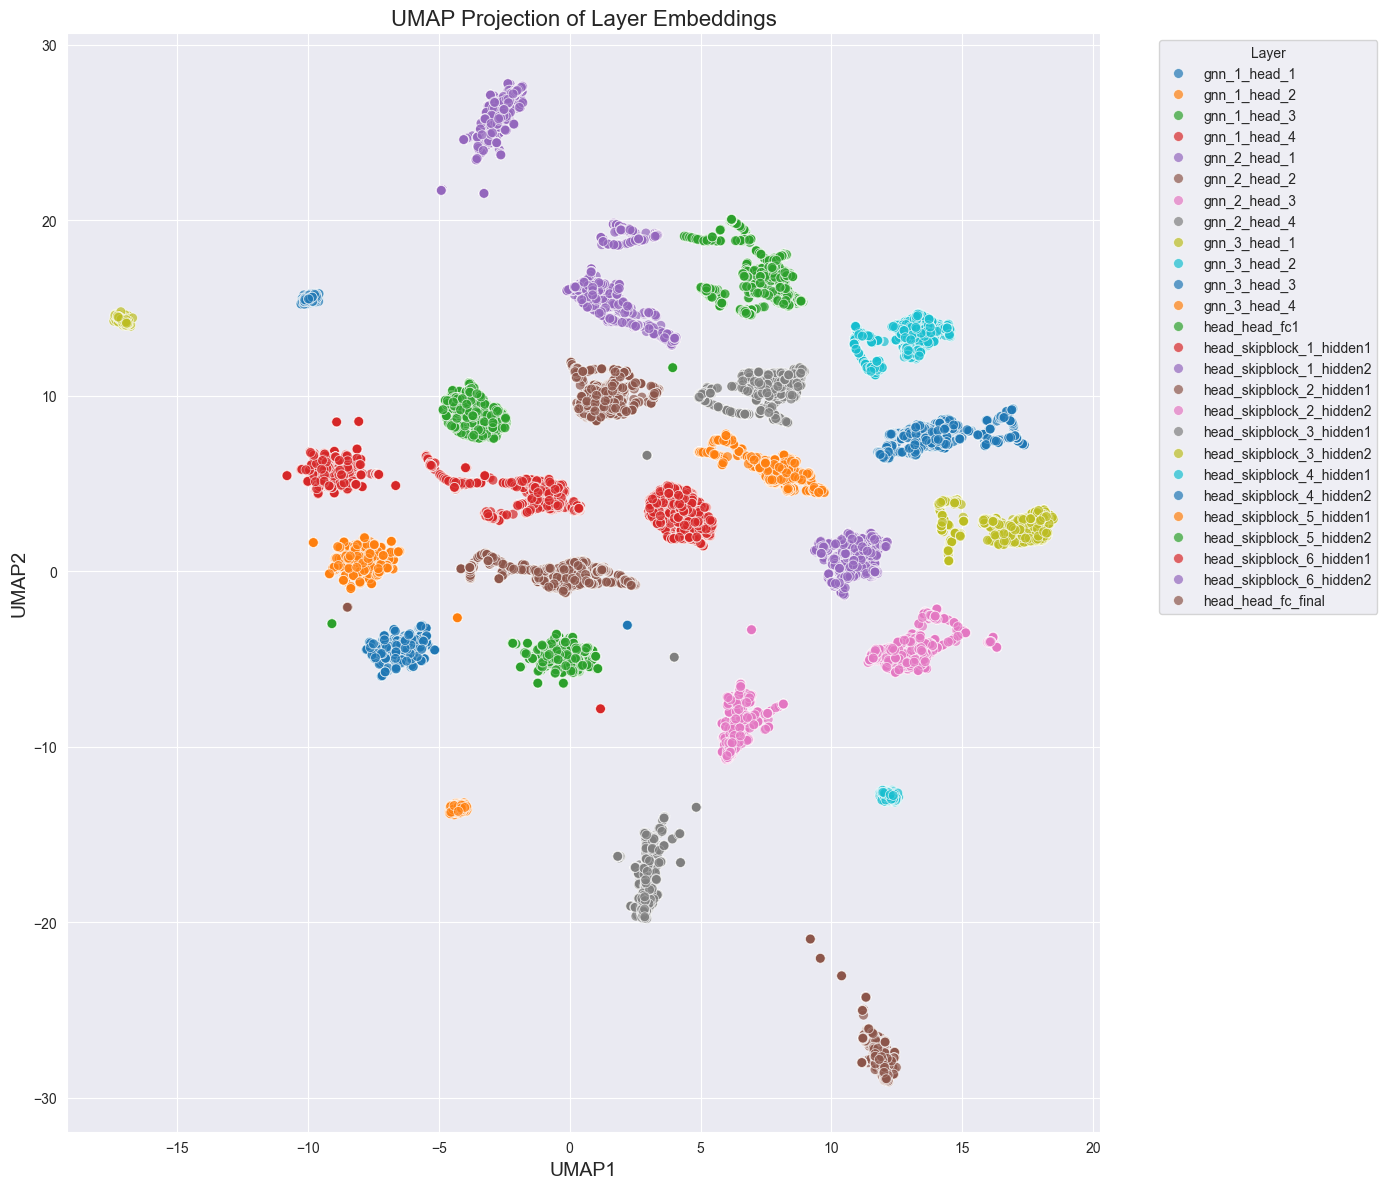

In [19]:
project_embeddings_umap(
    embeddings_dict=embeddings_model1,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    figsize=(14, 12),
    save_path=None
)

## Plot heat map for each data separately

In [34]:
experiment_dirs = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_01-33-16',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_02-12-27',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_02-54-27',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'
]


In [ ]:
# Compute CKA matrices for all 4 experiments
cka_matrices = compute_all_cka_matrices(experiment_dirs, layer_names)


Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_01-33-16


Outer loop:  12%|█▏        | 3/26 [00:24<03:10,  8.27s/it]

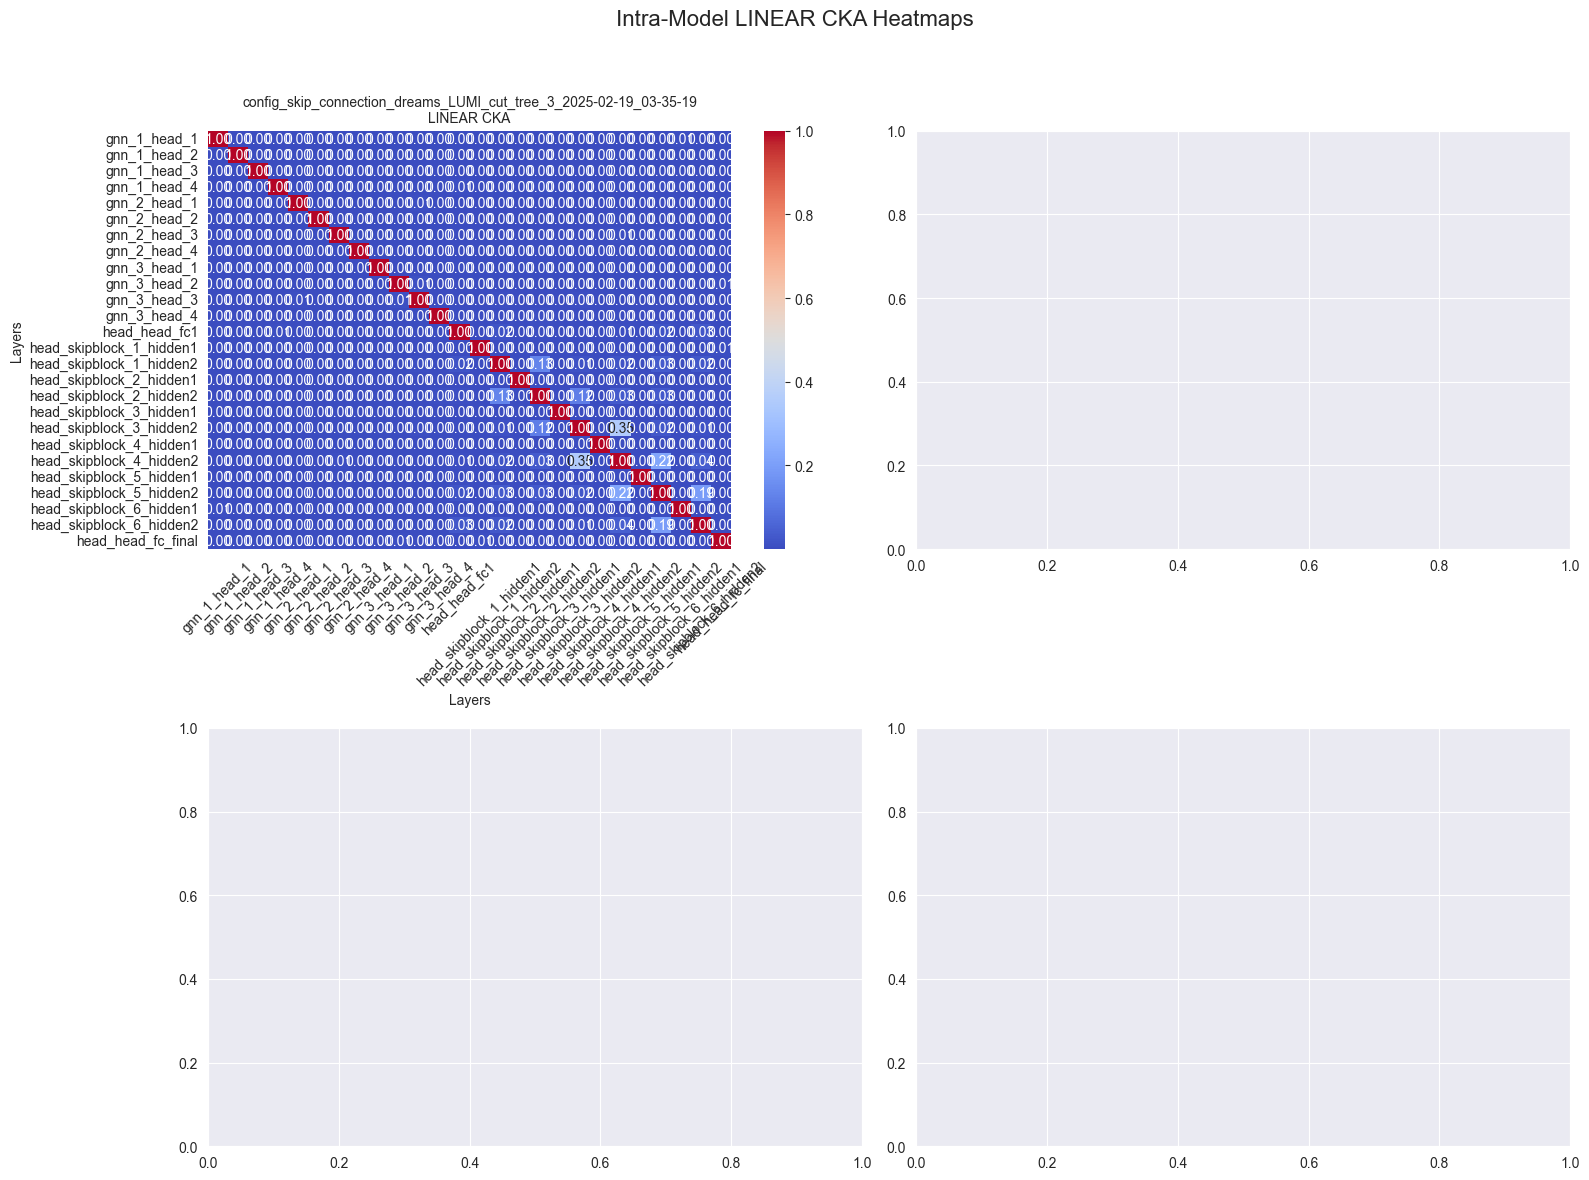

In [31]:
# Plot the 4 linear CKA heatmaps in one figure
plot_all_heatmaps(cka_matrices, layer_names, metric='linear')

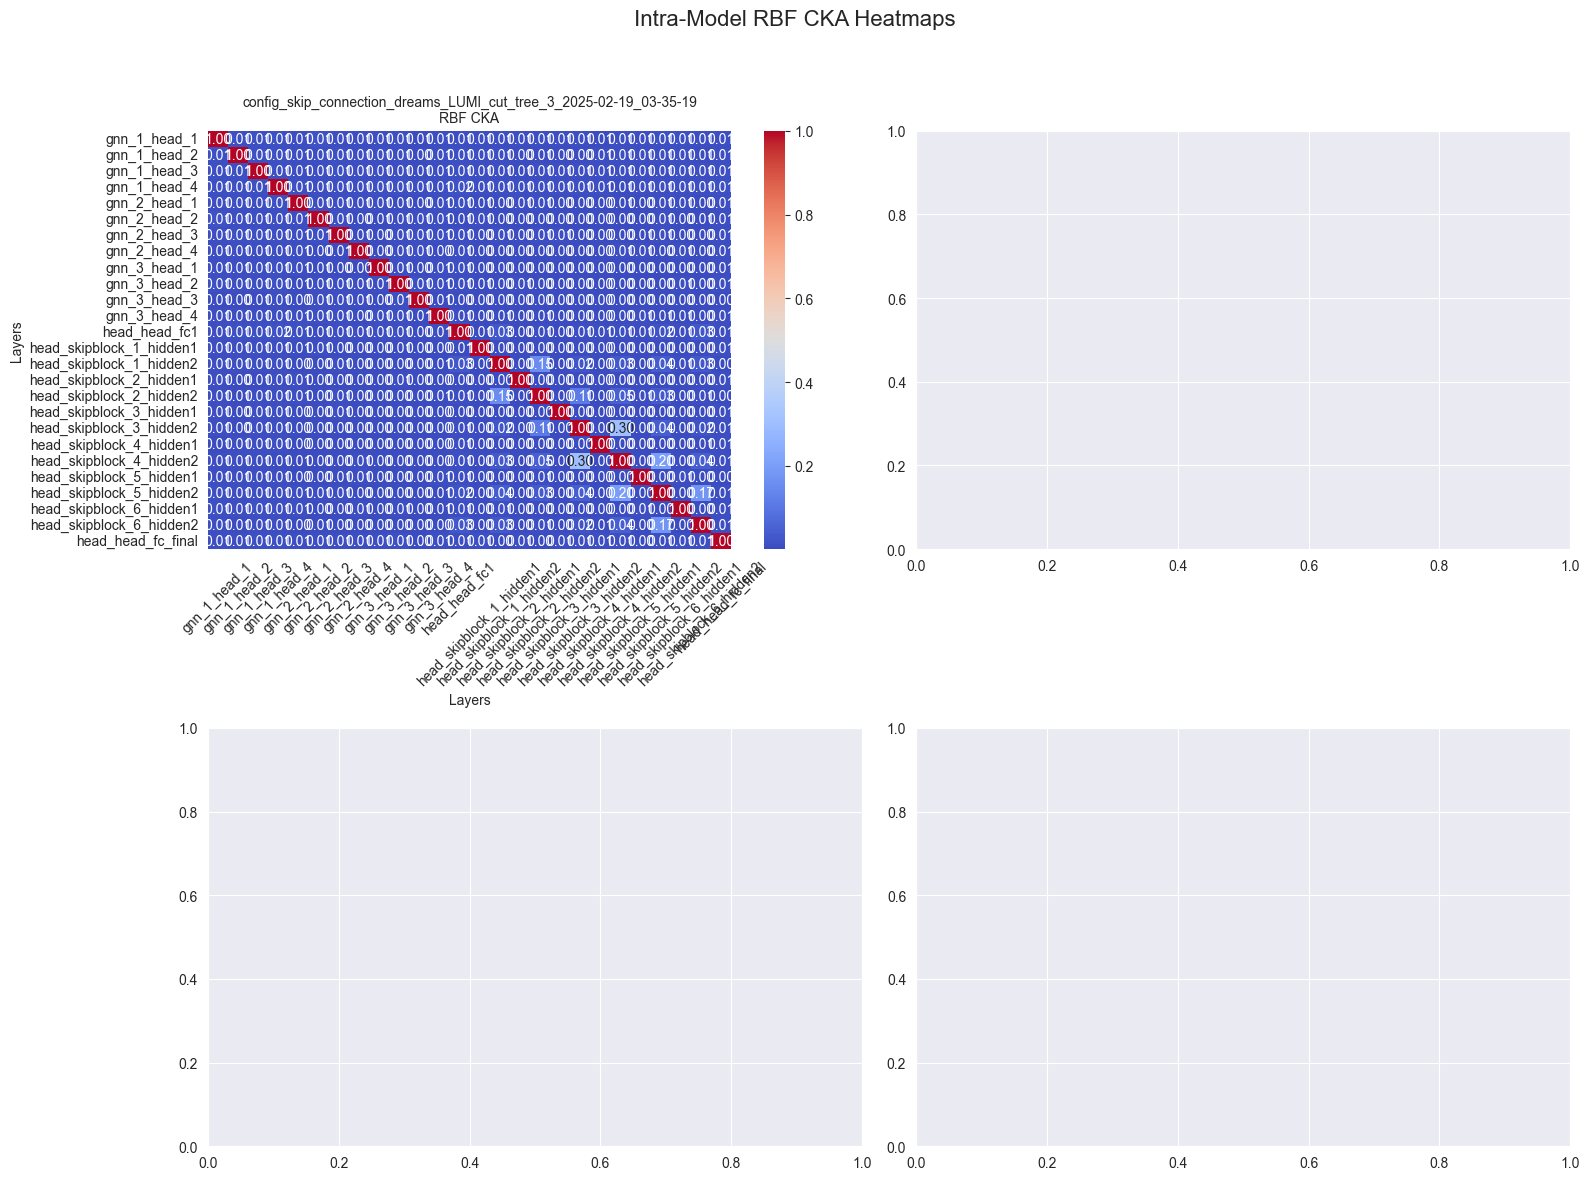

In [32]:
# Plot the 4 RBF kernel CKA heatmaps in one figure
plot_all_heatmaps(cka_matrices, layer_names, metric='rbf')